## Prepare Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from autogluon.timeseries import TimeSeriesDataFrame
import glob

features = ['unix_timestamp', 'open', 'high', 'low', 'close', 'volume'] # full
SEQ_LENGTH = 78  # 5 hours of history (60 * 5min)
START_YEAR = 2019
DATASET_MONTHS = 72
STOCK_NAME = "IBM"

def GetDataSetFileName(year, month):
    return f"DataSets/{STOCK_NAME}/{year}/intraday_{year}_{month:02d}_5min_{STOCK_NAME}.csv"

def LoadDataFromFile(start_year, start_month, dataset_months):
    #global df, ts_df, df_chronos

    df_list = [pd.read_csv(GetDataSetFileName(i // 12 + start_year, i % 12 + 1)) for i in range(start_month - 1, dataset_months + start_month - 1)]
    df = pd.concat(df_list, ignore_index=True)

    # Ensure datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')

    # Set timestamp as index
    #df = df.set_index('timestamp')

    daily = (
        df
        .set_index('timestamp')
        .resample('5min')
        .last()        # take last available tick as “close”
        #.ffill()       # forward-fill weekends/holidays
        .interpolate(method='time')
        .reset_index()
    )

    # Create full range (from first to last timestamp)
    #full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='5min')

    # Reindex to full time range, introducing NaNs
    #df_full = df.reindex(full_index)

    # Reset index and rename
    #df_full = df_full.reset_index().rename(columns={"index": "timestamp"})

    # Add item_id
    daily['item_id'] = STOCK_NAME

    # Select columns for Chronos
    df_chronos = daily[['item_id', 'timestamp', 'close']].rename(columns={'close': 'target'})

    #df_chronos['target'] = df_chronos['target'].ffill()
    #df_chronos = df_chronos.reset_index()

    return df_chronos

## Predict

In [2]:
from autogluon.timeseries import TimeSeriesPredictor

# Load the first batch of data
df_chronos = LoadDataFromFile(START_YEAR, 1, DATASET_MONTHS)
ts_df = TimeSeriesDataFrame(df_chronos)

print(ts_df)

# Calculate the cutoff point
split_idx = int(len(ts_df)) - (600 * 12)
#split_idx = int(len(ts_df) * 0.99)

# Split into train/test
# train_data = ts_df.slice_intersect(None, ts_df.index[split_idx - 1][1])
# test_data = ts_df.slice_intersect(ts_df.index[split_idx][1], None)

train_data = ts_df.iloc[:split_idx]
test_data = ts_df.iloc[split_idx:]

# Number of points to forecast
prediction_length = len(test_data)

predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    freq='5min',  # or 'D', 'H', depending on timestamp spacing
    #verbosity=2
)

predictor.fit(
    train_data,
    presets="high_quality",  # longer training time, better results
    time_limit = 900,
    hyperparameters={
        # 'Chronos': {
        #     'model_path': 'bolt_base',
        #     'trainer_kwargs': {
        #         'accelerator': 'cpu',  # Enables GPU
        #         'devices': 1,
        #     }
        # },
        "Chronos": [
            # {"model_path": "bolt_tiny",
            # #"context_length": 96,
            # #"prediction_length": prediction_length,
            # #"learning_rate": 5e-4,
            # #"dropout_rate": 0.1,
            # #"batch_size": 64,
            # #"fine_tune": True,
            # #"max_epochs": 20,
            # "trainer_kwargs": {
            #     "accelerator": "gpu",
            #     "devices": 1,
            # }},
            # {"model_path": "bolt_base",
            #  "fine_tune": False,
            #  "max_time_limit": 20,
            #  #"ag_args": {"name_suffix": "FineTuned"},
            #  "trainer_kwargs": {
            #     "accelerator": "gpu",
            #     "devices": 1,
            # }},
            {"model_path": "bolt_small",
             "fine_tune": True,
             #"max_time_limit_ratio": 0.45,
             "ag_args": {"name_suffix": "FineTuned"},
             "trainer_kwargs": {
                "accelerator": "gpu",
                "devices": 1,
            }},
            # {"model_path": "bolt_mini",
            #  "fine_tune": True,
            #  "max_time_limit_ratio": 0.45,
            #  "ag_args": {"name_suffix": "FineTuned"},
            #  "trainer_kwargs": {
            #     "accelerator": "gpu",
            #     "devices": 1,
            # }}
        ]
        # "DeepAR": {
        #     "trainer_kwargs": {
        #         "accelerator": "gpu",  # Use "gpu" for CUDA
        #         "devices": 1,           # or more if you have multiple GPUs
        #         "max_epochs": 2
        #     }
        # },
        # "ETS": {
        #         'trainer_kwargs': {
        #         'accelerator': 'gpu',  # Enables GPU
        #         'devices': 1,
        #     }
        # }      # Use default config
    }
)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/media/not-a-dev/01D58081E1A856A0/Users/gmaci/Documents/AGH/Semestr_6/AI/Itsy-Bitsy-Teenie-Weenie-Little-Stock-Prediction-Geenie/AutogluonModels/ag-20250526_205630'


                                target
item_id timestamp                     
IBM     2019-01-02 06:25:00   80.49200
        2019-01-02 06:30:00   80.51250
        2019-01-02 06:35:00   80.53300
        2019-01-02 06:40:00   80.55350
        2019-01-02 06:45:00   80.57400
...                                ...
        2024-12-31 19:25:00  216.94420
        2024-12-31 19:30:00  217.00835
        2024-12-31 19:35:00  217.07250
        2024-12-31 19:40:00  216.94420
        2024-12-31 19:45:00  217.06260

[630881 rows x 1 columns]


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.3
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #26~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Apr 17 19:20:47 UTC 2
CPU Count:          24
GPU Count:          1
Memory Avail:       31.71 GB / 46.97 GB (67.5%)
Disk Space Avail:   167.05 GB / 931.02 GB (17.9%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': '5min',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small',
                                  'trainer_kwargs': {'accelerator': 'gpu',
                                                     'devices': 1}}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 7200,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'rando

Forecast for ChronosFineTuned[bolt_small]:


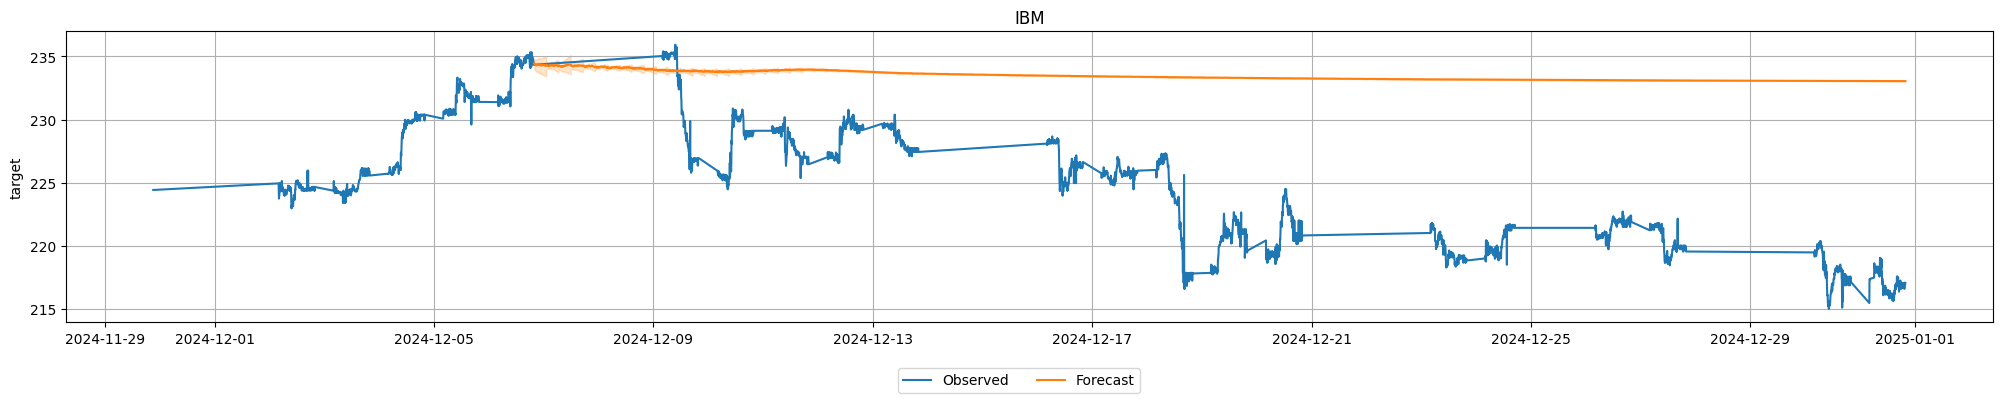

In [3]:
models = predictor.model_names()

for model in models:
    forecast = predictor.predict(train_data, model=model)
    print(f"Forecast for {model}:")
    predictor.plot(
        data=ts_df,
        predictions=forecast,
        item_ids=train_data.item_ids,
        max_history_length=prediction_length+2000
    )

## Graph Results

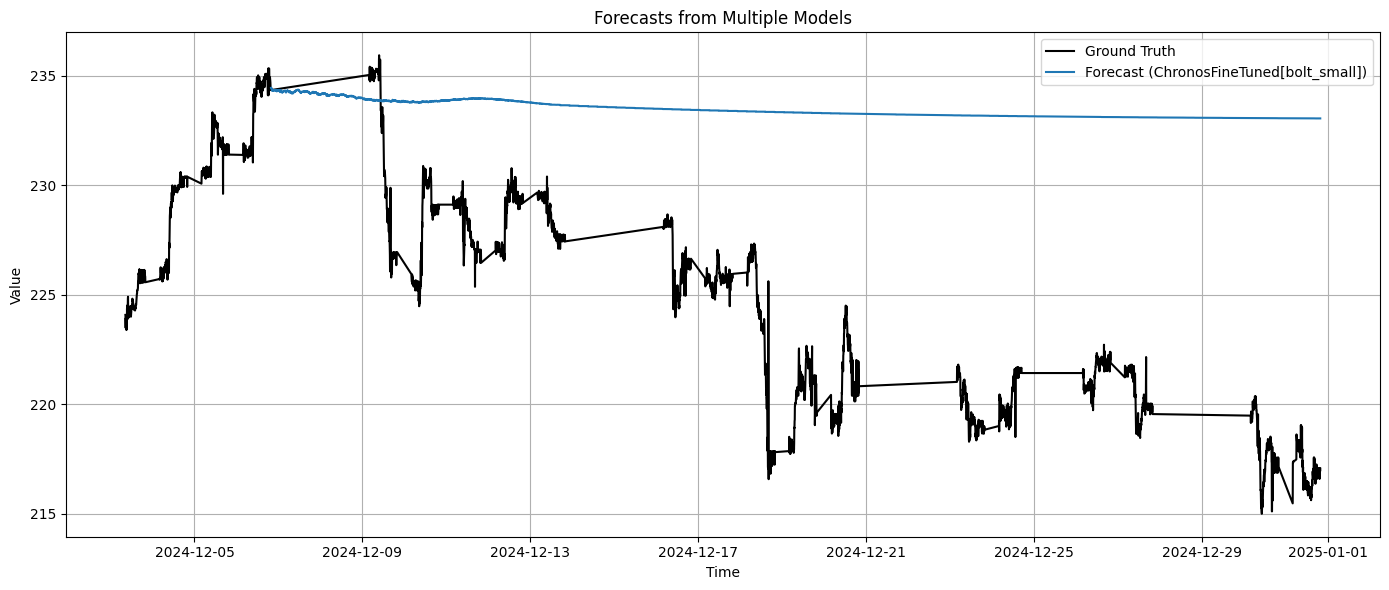

In [4]:
import matplotlib.pyplot as plt

models = predictor.model_names()

plt.figure(figsize=(14, 6))

# Plot ground truth
#full_series = df_chronos.set_index("timestamp")["target"]
#plt.plot(full_series, label="Ground Truth", color="black")

# Plot real values
full_series = ts_df.iloc[(split_idx - 1000):].to_data_frame().reset_index().set_index('timestamp')['target']
plt.plot(full_series, label="Ground Truth", color="black")

# Plot all model forecasts
for model in models:
    forecast = predictor.predict(train_data, model=model)
    forecast_df = forecast.to_data_frame().reset_index()
    forecast_series = forecast_df.set_index("timestamp")["mean"]
    plt.plot(forecast_series, label=f"Forecast ({model})")

plt.title("Forecasts from Multiple Models")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]


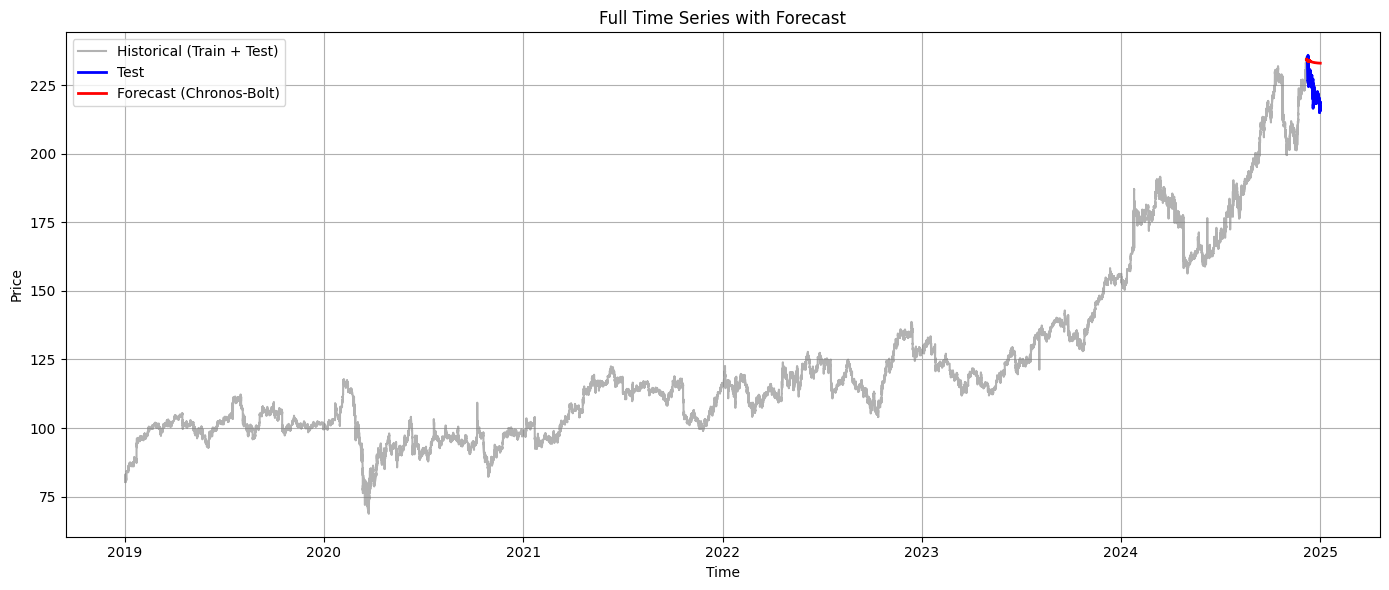

In [5]:
import matplotlib.pyplot as plt

# Full target series
full_df = df_chronos.copy()
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
full_df = full_df.set_index('timestamp')
full_series = full_df['target']

# Get forecast DataFrame
forecast = predictor.predict(train_data)
forecast_df = forecast.to_data_frame().reset_index()
forecast_series = forecast_df.set_index('timestamp')['mean']

# Get test series (for evaluation)
test_series = test_data.to_data_frame().reset_index().set_index('timestamp')['target']

# Plot full data with forecast starting where it should
plt.figure(figsize=(14, 6))

# Plot all historical data (train + test)
plt.plot(full_series, label="Historical (Train + Test)", color='gray', alpha=0.6)

# Highlight test data
plt.plot(test_series, label="Test", color='blue', linewidth=2)

# Plot forecast (starting after training)
plt.plot(forecast_series, label="Forecast (Chronos-Bolt)", color='red', linewidth=2)

plt.title("Full Time Series with Forecast")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Load models

Loading predictor from path /media/not-a-dev/01D58081E1A856A0/Users/gmaci/Documents/AGH/Semestr_6/AI/Itsy-Bitsy-Teenie-Weenie-Little-Stock-Prediction-Geenie/AutogluonModels/ag-20250526_205630


['ChronosFineTuned[bolt_small]']
                                target
item_id timestamp                     
IBM     2024-10-01 04:00:00  216.02270
        2024-10-01 04:05:00  216.02270
        2024-10-01 04:10:00  216.02270
        2024-10-01 04:15:00  216.10590
        2024-10-01 04:20:00  216.18910
...                                ...
        2024-12-31 19:25:00  216.94420
        2024-12-31 19:30:00  217.00835
        2024-12-31 19:35:00  217.07250
        2024-12-31 19:40:00  216.94420
        2024-12-31 19:45:00  217.06260

[26398 rows x 1 columns]


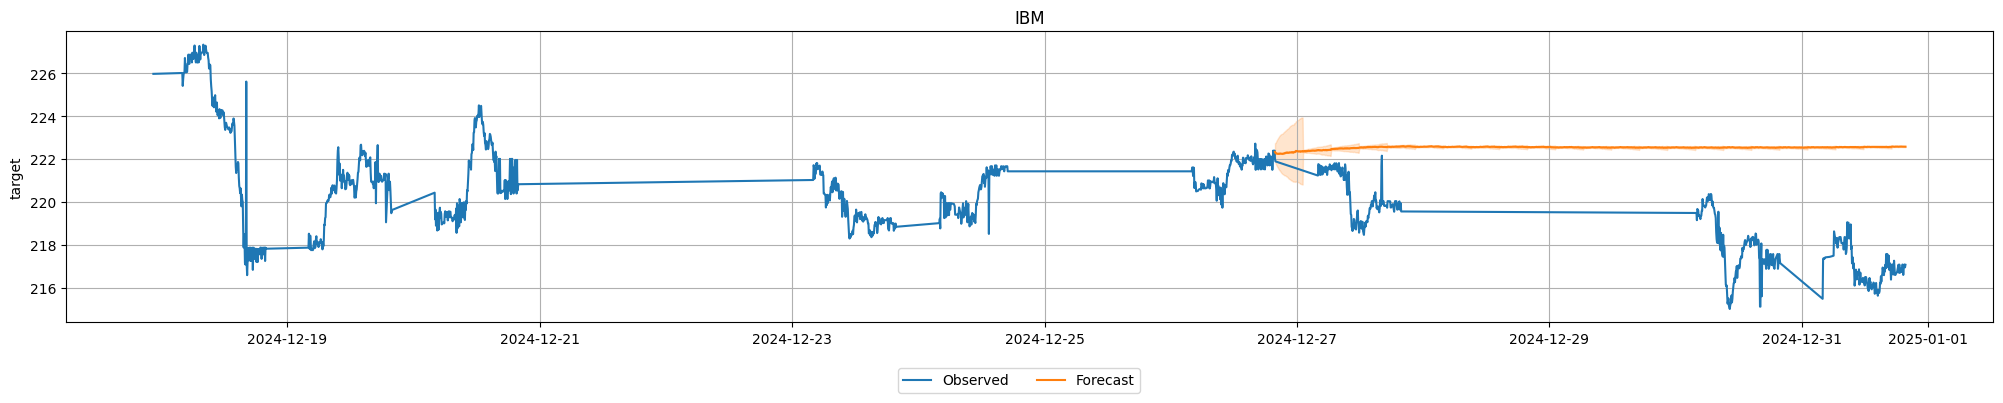

In [7]:
from autogluon.timeseries import TimeSeriesPredictor

predictor = TimeSeriesPredictor.load("AutogluonModels/ag-20250526_205630")

print(predictor.model_names())

df = LoadDataFromFile(2024, 10, 3)

ts_df1 = TimeSeriesDataFrame(df)

print(ts_df1)

extrapolate_len = 120 * 12
#extrapolate_idx = len(df) - extrapolate_len

ts_old, ts_new = ts_df1.train_test_split(extrapolate_len)

# ts_old = ts_df1.iloc[:extrapolate_idx]
# ts_new = ts_df1.iloc[extrapolate_idx:]

forecast1 = predictor.predict(ts_old, model=predictor.model_names()[-1]).head(extrapolate_len)

predictor.plot(
    data=ts_df1,
    predictions=forecast1,
    item_ids=ts_new.item_ids,
    max_history_length=4000,
)
